<a href="https://colab.research.google.com/github/GeorgeSherif/NLP-ChatEGP/blob/main/Model%20Without%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing & Importing the Necessary Libraries and Mounting the drive**

In [56]:
!pip3 install transformers sentencepiece protobuf torch pygal torchvision sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
from google.colab import drive
from IPython.display import display # Allows the use of display() for DataFrames
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [58]:
import pandas as pd
import numpy as np
import os
import warnings
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import pygal as py
import matplotlib
plt.rcParams["figure.figsize"] = (8,5)
matplotlib.rc('xtick', labelsize=7) 
matplotlib.rc('ytick', labelsize=7) 

import torch
import torchvision

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline 

In [59]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Approach 1: Evaluate the English Model (BERT)**


*   English Train Data
*   Arabic Test Data
*   Train with the English Dataset
*   Translate the Arabic Dataset
*   Evaluate Model





### Load the English Dataset

In [60]:
df = pd.read_csv('/content/gdrive/MyDrive/NLP/English Dataset.csv' ,engine="python", encoding = "ISO-8859-1")
#df = pd.read_csv('/content/gdrive/MyDrive/NLP/preprocessed.csv' ,engine="python", encoding = "ISO-8859-1")
print((df['Sentiment'] == 'neutral').sum())


2879


In [61]:
num_entries_to_remove_positive = (df['Sentiment'] == 'positive').sum() - (df['Sentiment'] == 'negative').sum()
num_entries_to_remove_neutral = (df['Sentiment'] == 'neutral').sum() - (df['Sentiment'] == 'negative').sum()
print(num_entries_to_remove_neutral)


indices_to_remove = df[df['Sentiment'] == 'positive'].sample(num_entries_to_remove_positive).index
dfPositive = df[df['Sentiment'] == 'positive'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'neutral'].sample(num_entries_to_remove_neutral).index
dfNeutral = df[df['Sentiment'] == 'neutral'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'negative'].sample(0).index
dfNegative = df[df['Sentiment'] == 'negative'].drop(indices_to_remove)

print(dfNegative)

2275
     Sentiment                                           Sentence
2     negative  The international electronic industry company ...
415   negative  A tinyurl link takes users to a scamming site ...
421   negative  Compared with the FTSE 100 index , which rose ...
423   negative  Compared with the FTSE 100 index , which rose ...
500   negative  One of the challenges in the oil production in...
...        ...                                                ...
4840  negative  HELSINKI Thomson Financial - Shares in Cargote...
4841  negative  LONDON MarketWatch -- Share prices ended lower...
4843  negative  Operating profit fell to EUR 35.4 mn from EUR ...
4844  negative  Net sales of the Paper segment decreased to EU...
4845  negative  Sales in Finland decreased by 10.5 % in Januar...

[604 rows x 2 columns]


In [62]:
dfNew = pd.concat((dfNegative, dfNeutral, dfPositive), axis = 0)
dfNew
df = dfNew

In [63]:
df['Sentiment'] = df['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])
df

,Sentiment,Sentence
2,0,The international electronic industry company ...
415,0,A tinyurl link takes users to a scamming site ...
421,0,"Compared with the FTSE 100 index , which rose ..."
423,0,"Compared with the FTSE 100 index , which rose ..."
500,0,One of the challenges in the oil production in...
...,...,...
4592,2,"In the fourth quarter of 2009 , Atria 's net l..."
4602,2,The two companies will also partner in further...
4773,2,"According to the company , its operating profi..."
4780,2,"The antibody , given at repeated doses of up t..."


<Axes: xlabel='count', ylabel='Sentiment'>

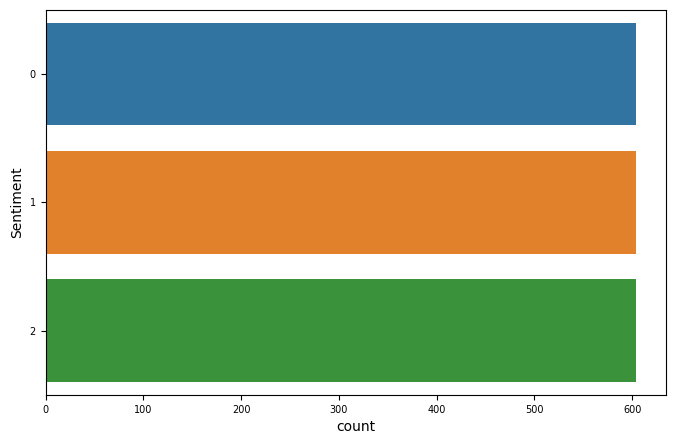

In [64]:
sns.countplot(y="Sentiment",data=df)

In [65]:
df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)
df

,Sentiment,Sentence
2,0,The international electronic industry company ...
415,0,A tinyurl link takes users to a scamming site ...
421,0,"Compared with the FTSE 100 index , which rose ..."
423,0,"Compared with the FTSE 100 index , which rose ..."
500,0,One of the challenges in the oil production in...
...,...,...
4592,2,"In the fourth quarter of 2009 , Atria 's net l..."
4602,2,The two companies will also partner in further...
4773,2,"According to the company , its operating profi..."
4780,2,"The antibody , given at repeated doses of up t..."


### Sentiment Analysis using BERT

In [66]:
from sklearn.model_selection import train_test_split
X_features = df["Sentence"]
Y_features = df["Sentiment"]
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.Sentiment.values, test_size=0.2, random_state=42, shuffle=True)

In [67]:
from transformers import BertTokenizer,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [68]:
df['data_type'] = ['not_set'] * df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

#groupby count
df.groupby([ 'Sentiment', 'data_type']).count()
#df = df.rename(columns={'Review Text': 'Sentence'})
df[df.data_type == 'train'].Sentence.values


array(['The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .',
       'A tinyurl link takes users to a scamming site promising that users can earn thousands of dollars by becoming a Google ( NASDAQ : GOOG ) Cash advertiser .',
       'Compared with the FTSE 100 index , which rose 36.7 points ( or 0.6 % ) on the day , this was a relative price change of -0.2 % .',
       ...,
       'According to the company , its operating profit , excluding non-recurring items , in the fourth quarter of 2009 was significantly better than expected , and also better than the figures for the fourth quarter of 2008 .',
       'The antibody , given at repeated doses of up to 8 mg-kg , was generally well tolerated , and the pharmacokinetic characteristics of BTT-1023 in psoriasis patients were consistent with those observed in a previ

In [69]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                 truncation=True,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus( df[df.data_type == 'val'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                               truncation=True,
                                                return_tensors = 'pt')

In [70]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].Sentiment.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].Sentiment.values)
     

In [71]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [72]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = batch_size) #since we don't have to do backpropagation for this step

In [73]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-7) #2e-5 > 5e-5
                 
epochs = 16

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps =len(dataloader_train)*epochs)


In [74]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [75]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [76]:
#accuracy score
def accuracy_per_class(preds, labels):
    #label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    correct = 0
    total = 0

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n -> {len(y_preds[y_preds==label]) / len(y_true)}')
        correct = correct + len(y_preds[y_preds==label])
        total = total + len(y_true)
    return correct / total

In [77]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [78]:
epochs_accuracies = []

In [79]:
from tqdm import tqdm

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLP/2_BERT_BeforePreProcessing_ft_epoch{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    true_vals.shape
    accuracy = accuracy_per_class(predictions, true_vals)
    epochs_accuracies.append(str(accuracy))
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    tqdm.write(f'Accuracy Score: {accuracy}')

  0%|          | 0/16 [00:48<?, ?it/s]


 Epoch {epoch}
Training loss: {loss_train_avg}



  6%|▋         | 1/16 [00:52<13:04, 52.32s/it]

Accuracy:115/128
 -> 0.8984375
Accuracy:75/107
 -> 0.7009345794392523
Accuracy:102/128
 -> 0.796875
Validation loss: 0.5271454923178839
F1 Score (weighted): 0.8040269758067651
Accuracy Score: 0.8044077134986226



  6%|▋         | 1/16 [01:37<13:04, 52.32s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 12%|█▎        | 2/16 [01:40<11:38, 49.91s/it]

Accuracy:120/128
 -> 0.9375
Accuracy:93/107
 -> 0.8691588785046729
Accuracy:97/128
 -> 0.7578125
Validation loss: 0.41485390463924926
F1 Score (weighted): 0.8533869264237967
Accuracy Score: 0.8539944903581267



 12%|█▎        | 2/16 [02:25<11:38, 49.91s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 19%|█▉        | 3/16 [02:29<10:41, 49.38s/it]

Accuracy:124/128
 -> 0.96875
Accuracy:86/107
 -> 0.8037383177570093
Accuracy:101/128
 -> 0.7890625
Validation loss: 0.5159976961617561
F1 Score (weighted): 0.8549993746712325
Accuracy Score: 0.8567493112947658



 19%|█▉        | 3/16 [03:14<10:41, 49.38s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 25%|██▌       | 4/16 [03:17<09:47, 48.98s/it]

Accuracy:123/128
 -> 0.9609375
Accuracy:85/107
 -> 0.794392523364486
Accuracy:98/128
 -> 0.765625
Validation loss: 0.729745463614919
F1 Score (weighted): 0.8409478832203734
Accuracy Score: 0.8429752066115702



 25%|██▌       | 4/16 [04:02<09:47, 48.98s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 31%|███▏      | 5/16 [04:06<08:57, 48.90s/it]

Accuracy:119/128
 -> 0.9296875
Accuracy:86/107
 -> 0.8037383177570093
Accuracy:103/128
 -> 0.8046875
Validation loss: 0.7029617356247795
F1 Score (weighted): 0.8486895094738232
Accuracy Score: 0.8484848484848485



 31%|███▏      | 5/16 [04:51<08:57, 48.90s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 38%|███▊      | 6/16 [04:54<08:06, 48.69s/it]

Accuracy:120/128
 -> 0.9375
Accuracy:92/107
 -> 0.8598130841121495
Accuracy:103/128
 -> 0.8046875
Validation loss: 0.7366807168607762
F1 Score (weighted): 0.8679885647734872
Accuracy Score: 0.8677685950413223



 38%|███▊      | 6/16 [05:39<08:06, 48.69s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 44%|████▍     | 7/16 [05:43<07:17, 48.61s/it]

Accuracy:122/128
 -> 0.953125
Accuracy:84/107
 -> 0.7850467289719626
Accuracy:109/128
 -> 0.8515625
Validation loss: 0.7564604848752345
F1 Score (weighted): 0.8672187807494363
Accuracy Score: 0.8677685950413223



 44%|████▍     | 7/16 [06:28<07:17, 48.61s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 50%|█████     | 8/16 [06:31<06:28, 48.58s/it]

Accuracy:120/128
 -> 0.9375
Accuracy:90/107
 -> 0.8411214953271028
Accuracy:101/128
 -> 0.7890625
Validation loss: 0.8119913641775898
F1 Score (weighted): 0.8571203688086805
Accuracy Score: 0.8567493112947658



 50%|█████     | 8/16 [07:16<06:28, 48.58s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 56%|█████▋    | 9/16 [07:19<05:39, 48.45s/it]

Accuracy:124/128
 -> 0.96875
Accuracy:86/107
 -> 0.8037383177570093
Accuracy:106/128
 -> 0.828125
Validation loss: 0.7755154389888048
F1 Score (weighted): 0.8698429216443518
Accuracy Score: 0.8705234159779615



 56%|█████▋    | 9/16 [08:04<05:39, 48.45s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 62%|██████▎   | 10/16 [08:07<04:50, 48.36s/it]

Accuracy:122/128
 -> 0.953125
Accuracy:92/107
 -> 0.8598130841121495
Accuracy:98/128
 -> 0.765625
Validation loss: 0.9027756083030355
F1 Score (weighted): 0.8592519588896038
Accuracy Score: 0.859504132231405



 62%|██████▎   | 10/16 [08:53<04:50, 48.36s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 69%|██████▉   | 11/16 [08:56<04:02, 48.43s/it]

Accuracy:120/128
 -> 0.9375
Accuracy:86/107
 -> 0.8037383177570093
Accuracy:102/128
 -> 0.796875
Validation loss: 0.9311604438686196
F1 Score (weighted): 0.8483368148751316
Accuracy Score: 0.8484848484848485



 69%|██████▉   | 11/16 [09:41<04:02, 48.43s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 75%|███████▌  | 12/16 [09:44<03:13, 48.43s/it]

Accuracy:119/128
 -> 0.9296875
Accuracy:85/107
 -> 0.794392523364486
Accuracy:106/128
 -> 0.828125
Validation loss: 0.9235475147345468
F1 Score (weighted): 0.8541157638379447
Accuracy Score: 0.8539944903581267



 75%|███████▌  | 12/16 [10:30<03:13, 48.43s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 81%|████████▏ | 13/16 [10:33<02:25, 48.48s/it]

Accuracy:118/128
 -> 0.921875
Accuracy:85/107
 -> 0.794392523364486
Accuracy:107/128
 -> 0.8359375
Validation loss: 0.9537744686474426
F1 Score (weighted): 0.8542391533106042
Accuracy Score: 0.8539944903581267



 81%|████████▏ | 13/16 [11:18<02:25, 48.48s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 88%|████████▊ | 14/16 [11:22<01:37, 48.55s/it]

Accuracy:120/128
 -> 0.9375
Accuracy:85/107
 -> 0.794392523364486
Accuracy:106/128
 -> 0.828125
Validation loss: 1.0309132606034046
F1 Score (weighted): 0.8565286482349634
Accuracy Score: 0.8567493112947658



 88%|████████▊ | 14/16 [12:07<01:37, 48.55s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 94%|█████████▍| 15/16 [12:11<00:48, 48.63s/it]

Accuracy:120/128
 -> 0.9375
Accuracy:86/107
 -> 0.8037383177570093
Accuracy:102/128
 -> 0.796875
Validation loss: 0.964271890352551
F1 Score (weighted): 0.8478432181498586
Accuracy Score: 0.8484848484848485



 94%|█████████▍| 15/16 [12:56<00:48, 48.63s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



100%|██████████| 16/16 [12:59<00:00, 48.74s/it]

Accuracy:120/128
 -> 0.9375
Accuracy:86/107
 -> 0.8037383177570093
Accuracy:102/128
 -> 0.796875
Validation loss: 0.9989014014028489
F1 Score (weighted): 0.8478432181498586
Accuracy Score: 0.8484848484848485


In [80]:
_, predictions, true_vals = evaluate(dataloader_val)

100%|██████████| 46/46 [00:03<00:00, 13.74it/s]


In [81]:
true_vals.shape
accuracy_per_class(predictions, true_vals)

Accuracy:120/128
 -> 0.9375
Accuracy:86/107
 -> 0.8037383177570093
Accuracy:102/128
 -> 0.796875


0.8484848484848485

In [82]:
 epochs_accuracies

['0.8044077134986226',
 '0.8539944903581267',
 '0.8567493112947658',
 '0.8429752066115702',
 '0.8484848484848485',
 '0.8677685950413223',
 '0.8677685950413223',
 '0.8567493112947658',
 '0.8705234159779615',
 '0.859504132231405',
 '0.8484848484848485',
 '0.8539944903581267',
 '0.8539944903581267',
 '0.8567493112947658',
 '0.8484848484848485',
 '0.8484848484848485']